# Analysis for the Recovery System

Okay, for the most part, this isn't analyzing drag for the recovery system yet, lol. Most of it is looking at the OpenRocket outputs and comparing them to DATCOM. In fact, this will probably get blobbed together as some omni-analysis for LV3 at some point. 

## Read in data; Sanity check on where/what

In [1]:
gamma=1.4 # C_p/C_v for air, taken to be constant

In [2]:
getwd()
if (!exists('par.default'))
    par.default <- par(no.readonly=T)
openRocketCSV <- "simData/LV3_L13_ideal_2017-5-30-1804.csv"
dat <- read.csv(openRocketCSV, skip=6)
datNames <- names(dat)
dat <- read.table(openRocketCSV, header= F, sep=',')
names(dat) <- datNames
head(dat)

# Print out the event lines from the CSV:
# system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv', intern = TRUE)
events <- as.numeric(system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[0-9]\\+\\.*[0-9]*\'', intern = TRUE))
events.names <- system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[[:upper:]_]\\{2,\\}\'', intern = TRUE)
names(events) <- events.names
events

[1] "/home/joedang/git/PSAS/lv3.0-airframe/sim"

X..Time..s.,Altitude..km.,Vertical.velocity..m.s.,Vertical.acceleration..m.s..,Total.velocity..m.s.,Total.acceleration..m.s..,Position.East.of.launch..km.,Position.North.of.launch..km.,Lateral.distance..km.,Lateral.direction....,⋯,Reference.length..in.,Reference.area..m..,Vertical.orientation..zenith.....,Lateral.orientation..azimuth.....,Wind.velocity..m.s.,Air.temperature...C.,Air.pressure..Pa.,Speed.of.sound..m.s.,Simulation.time.step..s.,Computation.time..s.
0.000,0.0000e+00,0.0000000,-6.85450,0.0000000,6.85450,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0039094
0.002,0.0000e+00,0.0000000,-0.96259,0.0000000,0.96259,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0064070
0.004,0.0000e+00,0.0000000,4.93030,0.0000000,4.93030,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0098882
0.006,9.8618e-09,0.0098621,10.82400,0.0098621,10.82400,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0113170
0.008,5.1236e-08,0.0315120,16.71800,0.0315120,16.71800,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0128110
0.010,1.4770e-07,0.0649510,22.61300,0.0649510,22.61300,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0142590


LAUNCH                   IGNITION 
                    0.0000                     0.0000 
                   LIFTOFF                  LAUNCHROD 
                    0.0380                     0.2800 
                   BURNOUT            EJECTION_CHARGE 
                    6.3242                     6.3242 
                    APOGEE RECOVERY_DEVICE_DEPLOYMENT 
                   34.8340                    35.3340 
RECOVERY_DEVICE_DEPLOYMENT                 GROUND_HIT 
                  217.7500                   250.6100 
            SIMULATION_END 
                  250.6100

In [3]:
# Print out the event lines from the CSV:
# system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv', intern = TRUE)
events <- as.numeric(system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[0-9]\\+\\.*[0-9]*\'', intern = TRUE))
events.names <- system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[[:upper:]_]\\{2,\\}\'', intern = TRUE)
names(events) <- events.names
# events

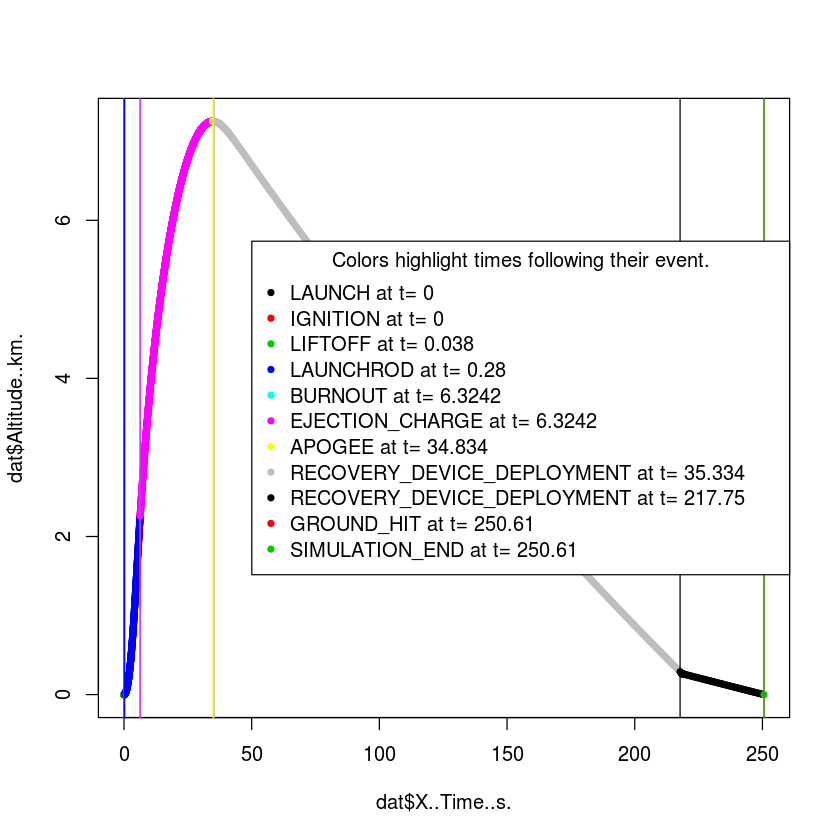

In [4]:
dat$colors <- sapply(dat$X..Time..s., function(t) sum(t>=events))
# layout(mat = matrix(c(1,2), nrow = 1))
plot(dat$X..Time..s., dat$Altitude..km., col=dat$colors, pch=20)
abline(v=events, col=1:length(events))
# text(
#     labels=names(events),
#     x=events,
#     y=seq(from=0, to=max(dat$Alt), length.out=length(events)),
#     col=1:length(events),
#     pos=4, srt=0, offset=-0.0
# )
legend(
    'right',
    legend=paste(names(events), 'at t=', events),
    col=1:length(events),
    pch=20,
    title='Colors highlight times following their event.'
)

In [5]:
ind <- which(
    dat$X..Time..s. > events['LAUNCHROD'] 
    & dat$X..Time..s. < events['APOGEE'] +2
)
launchlim <- range(dat$X..Time..s.[ind])

## Drag Calculations

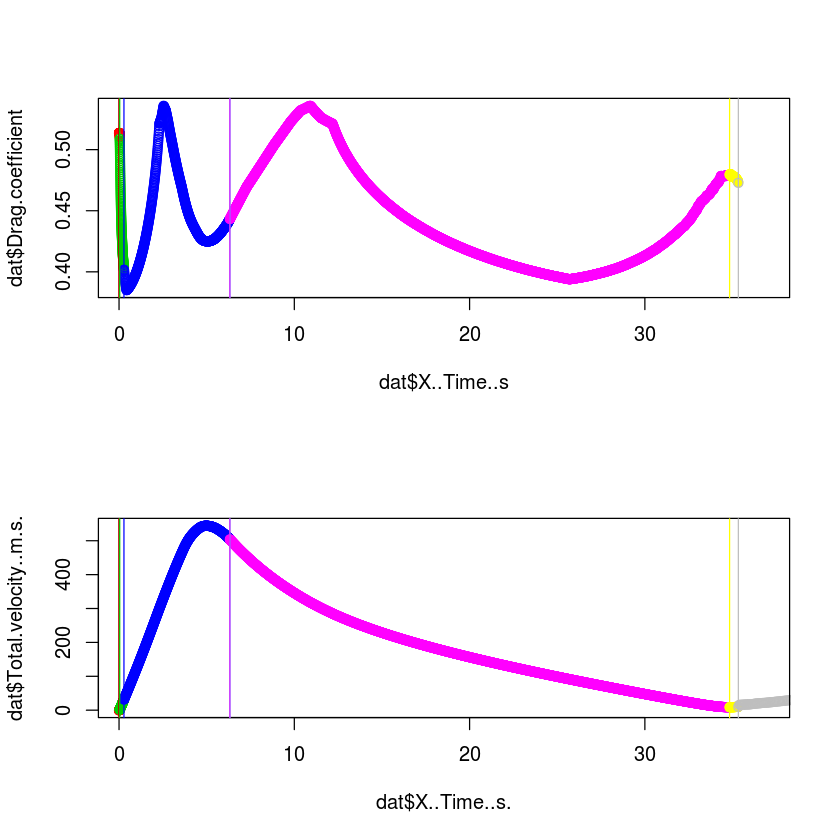

In [6]:
layout(matrix(c(1,2),nrow= 2))
plot(dat$X..Time..s, dat$Drag.coefficient, col=dat$col, xlim=launchlim)
abline(v=events, col=1:length(events))
plot(dat$X..Time..s., dat$Total.velocity..m.s., col=dat$col, xlim=launchlim)
abline(v=events, col=1:length(events))

## DATCOM comparisons

### create a schedule of test points

Scheduled test points are shown as numbers over the plots.

In [7]:
rodAlt <- dat$Altitude..km.[which(dat$X..Time..s.==events['LAUNCHROD'])]
ejectionAlt <- dat$Altitude..km.[which(dat$X..Time..s.==events['EJECTION_CHARGE'])]
alt.schedule.input <- c(0,rodAlt,0.02,0.1,0.4,0.8,1.4,ejectionAlt,3,5,7,max(dat$Alt))
# find the first index where we reach that altitude:
ind.schedule <- sapply(alt.schedule.input, function(x) which.max(dat$Alt >= x))

In [8]:
# schedule <- data.frame(matrix(ncol=0, nrow=length(alt.schedule)))
# for (name in names(dat))
# {
#     tempsch <- data.frame(approx(dat$Alt, dat[[name]], xout=alt.schedule, rule=2)$y)
#     names(tempsch) <- name
#     schedule <- cbind(schedule, tempsch)
# }
schedule <- dat[ind.schedule,]
schedule$test.number <- 1:length(ind.schedule)
schedule
write.csv(schedule, file='testPoints_OpenRocket.csv')

,X..Time..s.,Altitude..km.,Vertical.velocity..m.s.,Vertical.acceleration..m.s..,Total.velocity..m.s.,Total.acceleration..m.s..,Position.East.of.launch..km.,Position.North.of.launch..km.,Lateral.distance..km.,Lateral.direction....,⋯,Vertical.orientation..zenith.....,Lateral.orientation..azimuth.....,Wind.velocity..m.s.,Air.temperature...C.,Air.pressure..Pa.,Speed.of.sound..m.s.,Simulation.time.step..s.,Computation.time..s.,colors,test.number
1,0.00000,0.0000000,0.00000,-6.8545,0.0000,6.8545,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,⋯,90.000,0.00000000,NaN,6.03000,85832,334.95,0.002,0.0039094,2,1
141,0.28000,0.0040464,31.60300,123.5900,31.6030,123.5900,0.0000e+00,0.0000e+00,0.0000e+00,0.0000e+00,⋯,90.000,0.00000000,NaN,6.00370,85789,334.94,0.003,0.1539900,4,2
174,0.59425,0.0201100,70.78200,126.2000,70.7820,126.2000,-3.4086e-05,0.0000e+00,3.4086e-05,-1.8000e+02,⋯,89.598,0.00154770,NaN,5.89930,85619,334.87,0.010,0.2059800,4,3
244,1.29430,0.1011300,161.51000,133.1600,161.5600,133.7300,6.8931e-04,3.0081e-08,6.8931e-04,2.5003e-03,⋯,85.768,-0.00068207,NaN,5.37260,84757,334.55,0.010,0.2648900,4,4
367,2.52420,0.4031400,330.08000,134.2900,330.4100,134.7800,1.2455e-02,6.8687e-07,1.2455e-02,3.1597e-03,⋯,86.315,0.00699120,NaN,3.40960,81690,333.37,0.010,0.3703000,4,5
468,3.53420,0.8029400,458.66000,117.1400,459.2400,117.4500,3.1800e-02,3.4528e-06,3.1800e-02,6.2211e-03,⋯,86.586,0.00987460,NaN,0.81086,77734,331.79,0.010,0.4691600,4,6
586,4.71420,1.4041000,541.01000,21.4540,541.7600,21.5450,6.3027e-02,1.1206e-05,6.3027e-02,1.0187e-02,⋯,86.509,0.02160000,NaN,-3.09650,72084,329.42,0.010,0.5755700,4,7
747,6.32420,2.2600000,503.29000,-57.1350,504.0300,57.1940,1.0898e-01,2.9391e-05,1.0898e-01,1.5453e-02,⋯,86.367,0.01981500,NaN,-8.66020,64609,326.05,0.010,0.7522100,6,8
908,7.93420,3.0027000,422.97000,-43.5000,423.5900,43.5700,1.4923e-01,5.1563e-05,1.4923e-01,1.9797e-02,⋯,86.322,0.03460700,NaN,-13.48800,58646,323.13,0.010,0.8766100,6,9
1532,14.17400,5.0013000,243.26000,-18.5320,243.6800,18.5530,2.6109e-01,1.6138e-04,2.6109e-01,3.5414e-02,⋯,85.408,0.05943600,NaN,-26.47800,44782,315.25,0.010,1.4328000,6,10


In [9]:
# rodAlt <- dat$Altitude..km.[which(dat$X..Time..s.==events['LAUNCHROD'])]
# ejectionAlt <- dat$Altitude..km.[which(dat$X..Time..s.==events['EJECTION_CHARGE'])]
# schedule.alt.mach <- approx( # sample some altitude/mach number pairs with linear interpolation
#     dat$Alt[ind], dat$Mach[ind], 
#     xout=c(0,rodAlt,0.02,0.1,0.4,0.8,1.4,ejectionAlt,3,5,7,max(dat$Alt)), # hand-picked
#     rule=2
# )
# alt.schedule <- schedule.alt.mach$x
# mach.schedule <- schedule.alt.mach$y
# # stability margin caliber schedule:
# smc.schedule <- approx(dat$Alt[ind], dat$Stability.margin.calibers[ind], xout=alt.schedule, rule=2)$y
# aoa.schedule <- approx(dat$Alt[ind], dat$Angle[ind], xout=alt.schedule, rule=2)$y

### relevant variables as functions of time

max angle of attack during normal flight (launch rod to deployment): 41.876

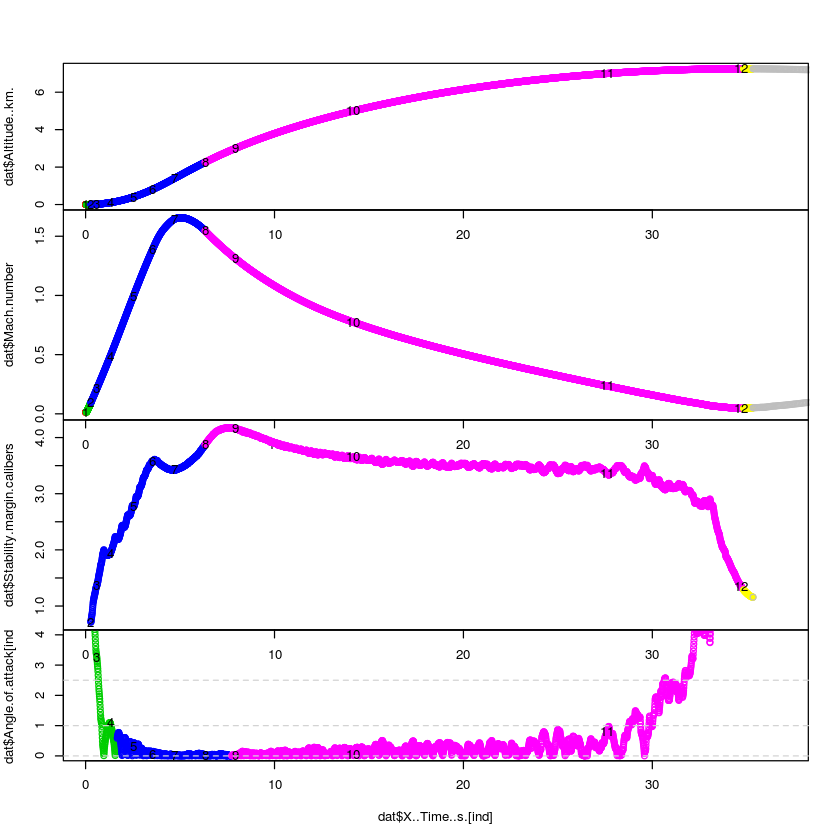

In [10]:
layout(matrix(c(1,2,3,4), nrow=4))
par.old <- par(mar=c(0,4,4,2)) # margins for top plot (bottom, left, top, right)
plot(dat$X..Time..s., dat$Altitude..km., xlim=launchlim, col=dat$col)
text(schedule$X..Time..s., schedule$Alt, schedule$test)
par(mar=c(0,4,0,2)) # margins for middle plot
plot(dat$X..Time..s., dat$Mach.number, xlim=launchlim, col=dat$col)
text(schedule$X..Time..s., schedule$Mach, schedule$test)
plot(dat$X..Time..s., dat$Stability.margin.calibers, xlim=launchlim, col=dat$col)
text(schedule$X..Time..s., schedule$Stability.margin, schedule$test)
par(mar=c(5,4,0,2)) # margins for bottom plot
plot(
    dat$X..Time..s.[ind], dat$Angle.of.attack[ind], 
    xlim=launchlim, 
    ylim=c(0,4),
    col=dat$col
)
text(schedule$X..Time..s., schedule$Angle, schedule$test)
abline(h=c(0,1,2.5,4.5), col='lightgray', lty=2)
cat('max angle of attack during normal flight (launch rod to deployment):', max(na.omit(dat$Angle.of.attack[ind])))

### relevant variables as functions of altitude

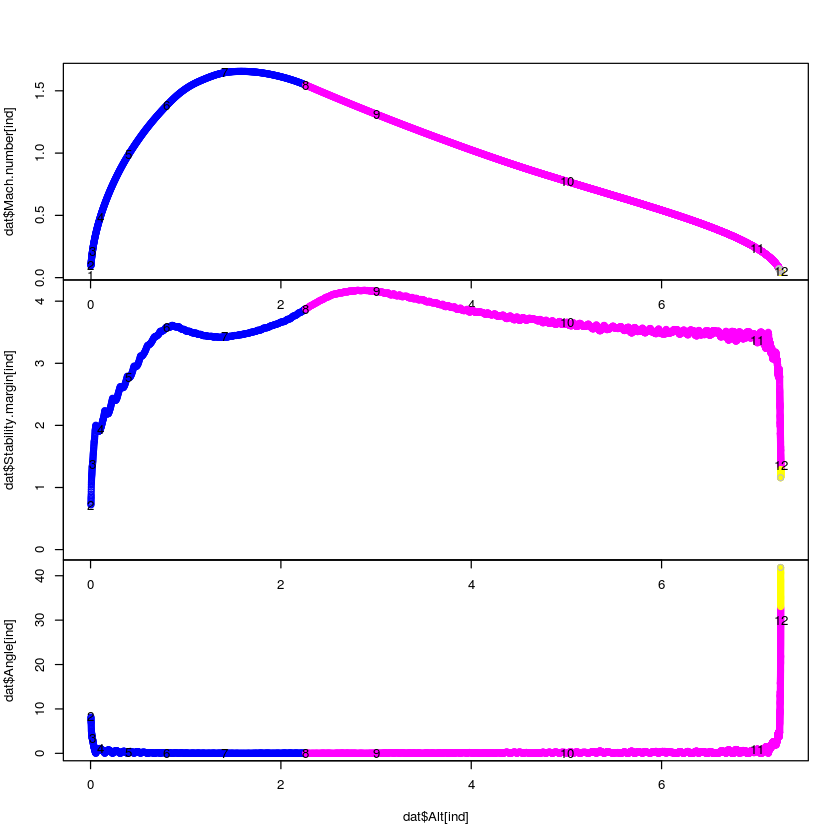

In [11]:
layout(matrix(c(1,2,3), nrow=3))
par(mar=c(0,4,4,2))
plot(dat$Altitude..km.[ind], dat$Mach.number[ind], col=dat$col[ind])
text(as.character(1:length(schedule$Alt)), x=schedule$Alt, y=schedule$Mach)
par(mar=c(0,4,0,2)) # margins for middle plot
plot(
    dat$Altitude..km.[ind], dat$Stability.margin[ind], 
    col=dat$col[ind], ylim=c(0, max(na.omit(dat$Stab)))
)
text(as.character(1:length(schedule$Alt)), x=schedule$Alt, y=schedule$Stability.margin)
par(mar=c(5,4,0,2))
plot(dat$Alt[ind], dat$Angle[ind], col=dat$col[ind])
text(as.character(1:length(schedule$Alt)), x=schedule$Alt, y=schedule$Angle)

par(par.old)
layout(1)

### inputs for altitude schedule and Mach schedule:

In [12]:
# DATCOM-friendly output:
alt.schedule.inch <- schedule$Alt*1e6/25.4 #convert from km into in
cat('##### INSERT VALUES THESE INTO THE DATCOM INPUT FILE: #####\n')
cat('NMACH=')
cat(sprintf('%1.1f', length(schedule$Mach))); cat(',')
cat('\nMACH=')
cat(toupper(format(schedule$Mach, scientific = T, digits=2)),sep=','); cat(',')
cat('\nNALT=')
cat(sprintf('%1.1f', length(schedule$Alt))); cat(',')
cat('\nALT=')
cat(toupper(format(alt.schedule.inch, scientific = T, digits=2)),sep=','); cat(',')

##### INSERT VALUES THESE INTO THE DATCOM INPUT FILE: #####
NMACH=12.0,
MACH=1.4E-02,9.5E-02,2.1E-01,4.8E-01,9.9E-01,1.4E+00,1.6E+00,1.5E+00,1.3E+00,7.7E-01,2.4E-01,4.7E-02,
NALT=12.0,
ALT=0.0E+00,1.6E+02,7.9E+02,4.0E+03,1.6E+04,3.2E+04,5.5E+04,8.9E+04,1.2E+05,2.0E+05,2.8E+05,2.9E+05,

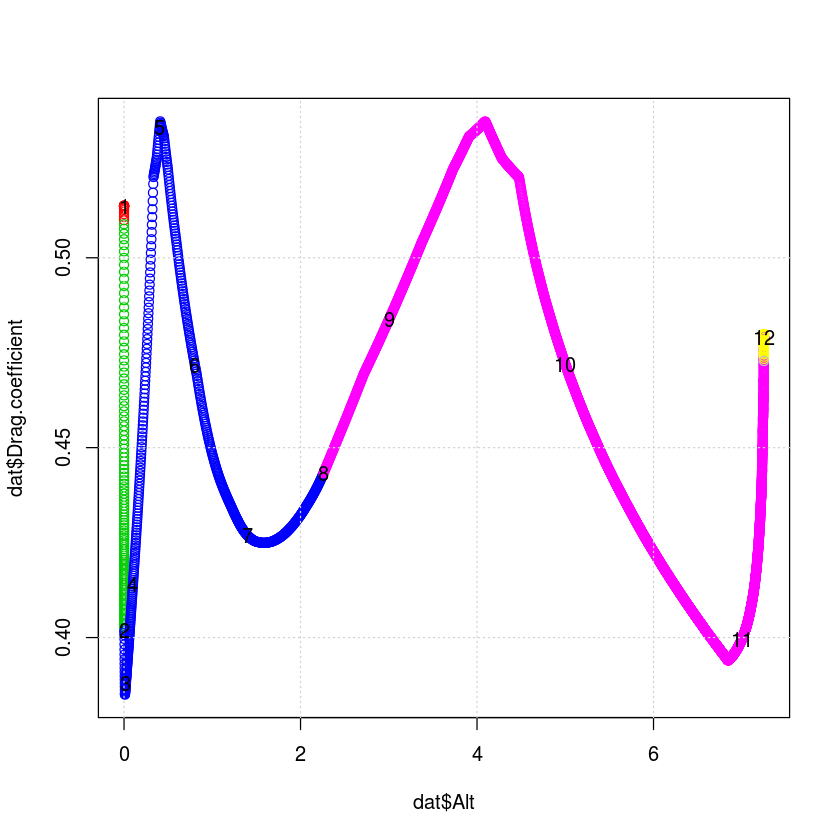

In [13]:
plot(dat$Alt, dat$Drag.coefficient, col=dat$col)
# drag.schedule <- approx(dat$Alt, dat$Drag.coeff, xout=alt.schedule, rule=2)$y
grid()
text(as.character(1:length(schedule$Alt)), x=schedule$Alt, y=schedule$Drag.coeff)

## Empirical Fin Loading

### turn the empirical data into callable functions and output some statistics on those fits

In [14]:
galdat.drag <- read.csv('plots/Gallagher1947_40trapezoid_bevel_CDpoints.txt', comment.char = '#')
galdat.lift <- read.csv('plots/Gallagher1947_40trapezoid_bevel_CLpoints.txt', comment.char = '#')

In [15]:
names(galdat.drag) <- c('alpha', 'CD')
names(galdat.lift) <- c('alpha', 'CL')
galdat.drag
galdat.lift

alpha,CD
5.4036,0.0723
7.5372,0.0931
10.5417,0.1347
10.7122,0.1310
13.7418,0.1672
15.8935,0.2279
17.8768,0.2775
21.0452,0.3578
21.7462,0.3787
24.7198,0.4621


alpha,CL
5.4091,0.1926
7.5300,0.2944
10.6395,0.4410
10.7377,0.4342
13.8273,0.5532
15.9514,0.6341
17.9788,0.7127
21.0218,0.8194
21.6798,0.8040
24.7747,0.8885



Call:
lm(formula = "CD ~ I(alpha^3) + I(alpha^2) + alpha", data = galdat.drag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0144032 -0.0025150  0.0005222  0.0025506  0.0074334 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.364e-02  8.579e-03   8.584 8.86e-08 ***
I(alpha^3)  -9.757e-06  5.912e-07 -16.503 2.58e-12 ***
I(alpha^2)   1.102e-03  4.942e-05  22.293 1.47e-14 ***
alpha       -5.440e-03  1.224e-03  -4.445 0.000313 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00512 on 18 degrees of freedom
Multiple R-squared:  0.9999,	Adjusted R-squared:  0.9998 
F-statistic: 4.593e+04 on 3 and 18 DF,  p-value: < 2.2e-16



Call:
lm(formula = "CL ~ I(alpha^3) + alpha + 0", data = galdat.lift)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.029190 -0.012054 -0.001207  0.011322  0.025364 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
I(alpha^3) -7.830e-06  1.637e-07  -47.82   <2e-16 ***
alpha       4.123e-02  2.766e-04  149.08   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01574 on 20 degrees of freedom
Multiple R-squared:  0.9997,	Adjusted R-squared:  0.9997 
F-statistic: 3.674e+04 on 2 and 20 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),5.561876e-02,9.166653e-02
I(alpha^3),-1.099906e-05,-8.514893e-06
I(alpha^2),9.978679e-04,1.205514e-03
alpha,-8.011762e-03,-2.868989e-03


,2.5 %,97.5 %
I(alpha^3),-8.171268e-06,-7.488236e-06
alpha,4.065520e-02,4.180904e-02


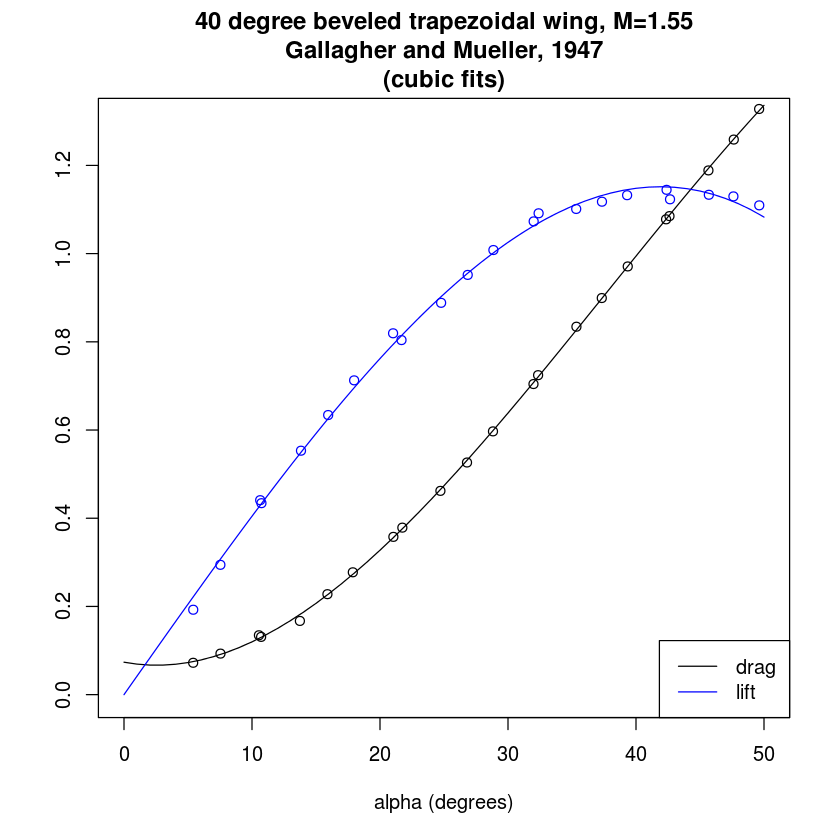

In [16]:
m.drag <- lm('CD ~ I(alpha^3) + I(alpha^2) + alpha', data = galdat.drag)
m.lift <- lm('CL ~ I(alpha^3) + alpha + 0', data = galdat.lift)
# m.lift <- lm('CL ~ alpha', data = galdat.lift)
summary(m.drag)
summary(m.lift)
confint(m.drag)
confint(m.lift)
galdrag <- function(alpha) predict(m.drag, data.frame(alpha=alpha))
gallift <- function(alpha) predict(m.lift, data.frame(alpha=alpha))
plot(
    galdat.drag$alpha, galdat.drag$CD, 
    xlim=c(0,50), ylim=c(0,1.3),
    main='40 degree beveled trapezoidal wing, M=1.55
Gallagher and Mueller, 1947
(cubic fits)',
    xlab='alpha (degrees)', ylab=NA
)
lines(0:50, galdrag(0:50))
points(galdat.lift$alpha, galdat.lift$CL, col='blue')
lines(0:50, gallift(0:50), col='blue')
legend(
    'bottomright',
    legend=c('drag', 'lift'),
    col=c('black', 'blue'),
    lty=1
)

### estimate normal loading for supersonic regime

In [17]:
semispan.exposed= 6.42*25.4/1e3 # meters
chord.root= 18*25.4/1e3 # meters
chord.tip= 5*25.4/1e3 # meters
fin.area <- semispan.exposed*(chord.root + chord.tip)/2
fin.area

[1] 0.04763216

$D = \frac{1}{2} \rho U^2 A C_D$  
$L = \frac{1}{2} \rho U^2 A C_L$

In [18]:
ind.super <- dat$Mach >= 1.2
mask.super <- sapply(ind.super, function(x) {if (x) x else NA})
dat$fin.CD <- galdrag(dat$Angle)*mask.super
dat$fin.CL <- galdrag(dat$Angle)*mask.super
dat$density <- gamma*dat$Air.pressure..Pa./dat$Speed.of.sound..m.s.^2
dat$fin.Drag <- 1/2*dat$density*dat$Total.velocity..m.s.^2*fin.area*dat$fin.CD
dat$fin.Lift <- 1/2*dat$density*dat$Total.velocity..m.s.^2*fin.area*dat$fin.CL

In [19]:
dat$fin.normalLoad <- dat$fin.Lift*cos(dat$Angle*2*pi/360) + dat$fin.Drag*sin(dat$Angle*2*pi/360)
dat$fin.tangentialLoad <- dat$fin.Lift*sin(dat$Angle*2*pi/360) - dat$fin.Drag*cos(dat$Angle*2*pi/360)
# plot(dat$fin.norm, type='l')
# plot(dat$fin.tang, type='l', col='blue')

In [20]:
fin.normalLoad.max= 450*4.448 # N (converted from pounds)
FS.fin.normal <- fin.normalLoad.max/max(dat$fin.norm, na.rm = T )

Neglecting tangential loading on the fins, the factor of safety for normal (out-of-plane) loading is:

In [21]:
FS.fin.normal

[1] 4.179863